In [1]:
import sys
sys.path.append('../')

from quantumsim import *
from pennylane import numpy as np
import matplotlib.pyplot as plt


def FHExacto(params):
    qubits = params["sites"]*2
    hopping = -params["hopping"]
    potential = params["potential"]
    fermi_sentence = 0.0

    if params["sites"] == 1:
        fermi_sentence +=  potential*FermiC(0)*FermiA(0)*FermiC(1)*FermiA(1)
    else:
        for i in range(params["sites"]-1):
            fermi_sentence +=  hopping*FermiC(2*i)*FermiA(2*i +2) + hopping*FermiC(2*i +2)*FermiA(2*i)
            fermi_sentence +=  hopping*FermiC(2*i+1)*FermiA(2*i +3) + hopping*FermiC(2*i +3)*FermiA(2*i +1)  
            fermi_sentence +=  potential*FermiC(2*i)*FermiA(2*i)*FermiC(2*i +1)*FermiA(2*i +1)

        if params["pattern"] == "close" and params["sites"] != 2:
            qsite = 2*(params["sites"]-1)
            fermi_sentence +=  hopping*FermiC(0)*FermiA(qsite) + hopping*FermiC(qsite)*FermiA(0)
            fermi_sentence +=  hopping*FermiC(1)*FermiA(qsite+1) + hopping*FermiC(qsite+1)*FermiA(1) 

    h = qml.jordan_wigner( fermi_sentence, ps=True).to_mat(wire_order=[i for i in range(qubits)])
    return np.sort( np.linalg.eigvals(h) )

# Analisis de hiperparametros

Para analizar los hiperparametros, consideraremos diferentes estructuras ya que manejamos diferentes tipos de hamiltonianos

1. 3 sitios con condiciones abiertas
2. 3 sitios con condiciones cerradas

Lo siguiente es ver que hiperparemetros vamos a estudiar:
1. Optimizador:
    1. Tipo de optimizador
    2. Learning rate (si corresponde)
2. Ansatz:
    1. Tipo de ansatz
    2. Repeticiones del ansatz

## Fermi-Hubbard

In [2]:
params1 = {
    "sites": 3,
    "hopping": -1, 
    "potential": 2,
    "pattern": "open"
}

hubbard_chain1 = vqe_fermihubbard(params1)
hubbard_chain1.set_group_characteristics()

params2 = {
    "sites": 3,
    "hopping": -1, 
    "potential": 2,
    "pattern": "close"
}

hubbard_chain2 = vqe_fermihubbard(params2)
hubbard_chain2.set_group_characteristics()


## Open model

In [3]:
valores = []
for k in range(4):
    print(k+1)
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": hubbard_chain1.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=hubbard_chain1.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    hubbard_chain1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
    valores.append(energy1)

1
2
3
4


/Users/jnorambu/Documents/vqesimulation/venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


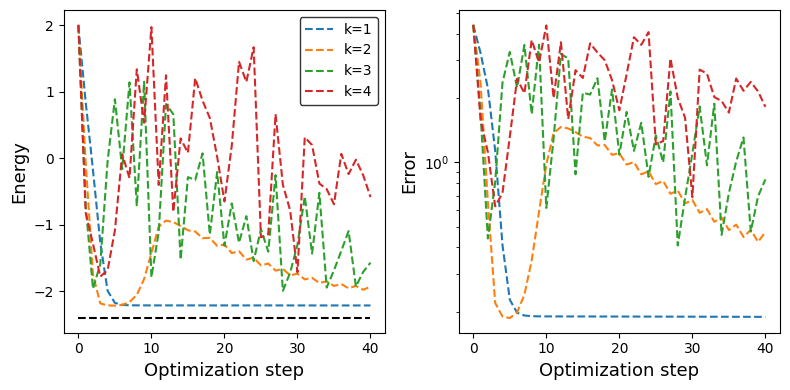

In [4]:
ee = FHExacto(params1)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

In [5]:
valores = []
for k in range(1):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": hubbard_chain1.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    hubbard_chain1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
    valores.append(energy1)

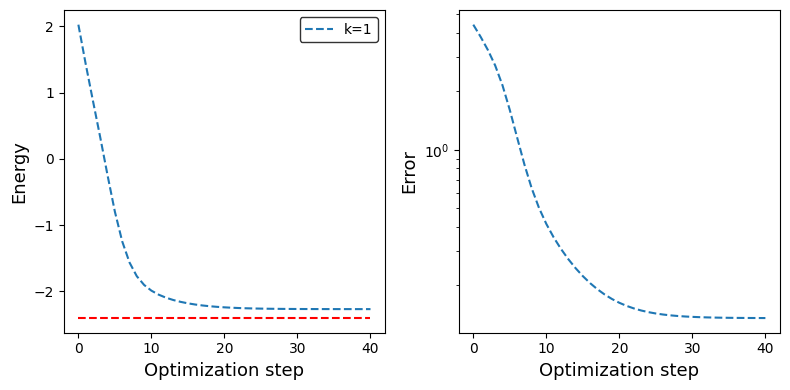

In [6]:
ee = FHExacto(params1)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], "r", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

In [7]:
ee = FHExacto(params1)

valores = []
for k in range(4):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": hubbard_chain1.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = he_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number": hubbard_chain1.qubits*ansatz_params["repetitions"],
            "theta":["generic", 0.3]}

    hubbard_chain1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function_parallel)
    valores.append(energy1)

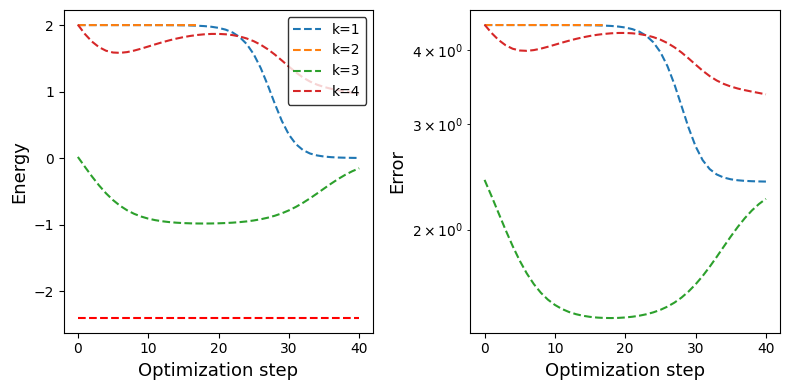

In [8]:
ee = FHExacto(params1)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], "r", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

## Closed Chain

In [11]:
valores = []
for k in range(4):
    print(k+1)
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": hubbard_chain2.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=hubbard_chain2.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    hubbard_chain2.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(hubbard_chain2.cost_function)
    valores.append(energy1)

1
2
3
4


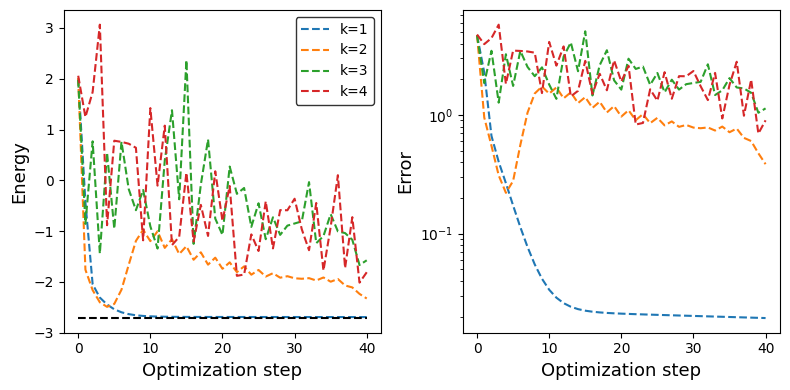

In [12]:
ee = FHExacto(params2)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

In [9]:
valores = []
for k in range(1):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": hubbard_chain2.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    hubbard_chain2.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(hubbard_chain2.cost_function)
    valores.append(energy1)

/Users/jnorambu/Documents/vqesimulation/venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


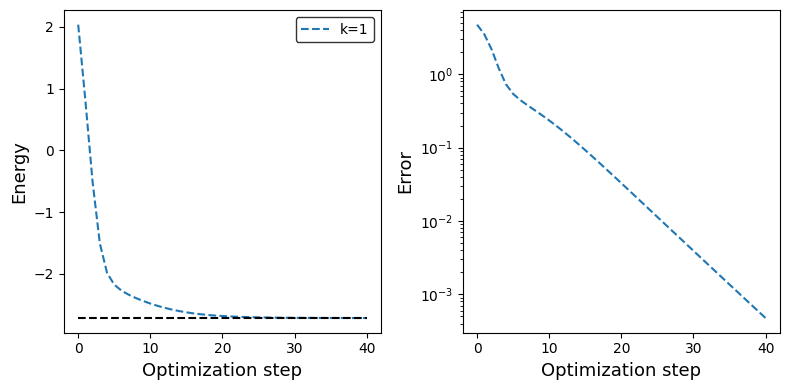

In [10]:
ee = FHExacto(params2)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

In [17]:
ee = FHExacto(params1)

valores = []
for k in range(4):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": hubbard_chain2.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = he_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number": hubbard_chain2.qubits*ansatz_params["repetitions"],
            "theta":["generic", 0.3]}

    hubbard_chain2.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(hubbard_chain2.cost_function_parallel)
    valores.append(energy1)

/Users/jnorambu/Documents/vqesimulation/venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


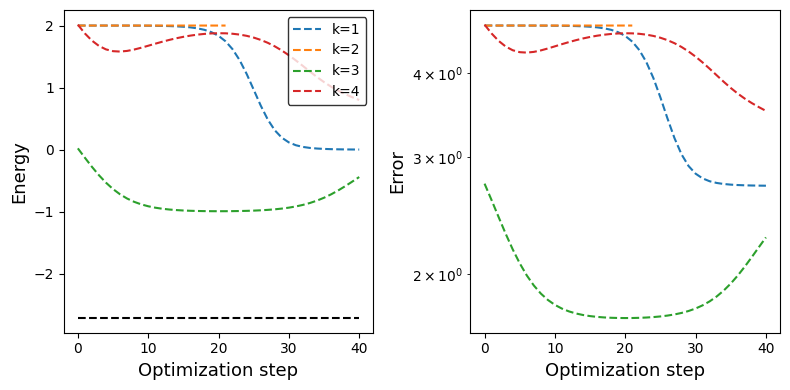

In [18]:
ee = FHExacto(params2)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()